In [ ]:
%cd /content/drive/MyDrive/CS 7389G

/content/drive/MyDrive/CS 7389G


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import the admissions.csv dataset and convert times to timastamp

In [ ]:
df1_adm=pd.read_csv("admissions.csv")
sorted_df1_adm = df1_adm.sort_values(by='admittime', ascending=True)

dt_adm=pd.to_datetime(sorted_df1_adm.admittime)
dt_disch=pd.to_datetime(sorted_df1_adm.dischtime)

los=[]
for item1, item2 in zip(dt_adm, dt_disch):
    duration = item2- item1
    duration_in_s = duration.total_seconds()
    los.append(duration_in_s/86400.00)
los
df=pd.DataFrame(data=los, index=dt_adm.index, columns=['los'])
dt_adm=pd.DataFrame(data=dt_adm, index=dt_adm.index)

In [ ]:
df_merge=dt_adm.merge(df, left_index=True, right_index=True)
df_filt=df_merge[df_merge.admittime>='01-01-2110']
df_filt
df_filt_index=df_filt.index

df_filt.set_index('admittime', inplace=True)
df_filt

,los
admittime,
2110-01-11 08:02:00,1.446528
2110-01-11 10:14:00,4.303472
2110-01-11 19:58:00,5.834722
2110-01-11 22:47:00,6.484722
2110-01-12 00:34:00,11.601389
...,...
2211-12-02 23:03:00,6.726389
2212-01-12 23:47:00,4.770833
2212-01-19 15:43:00,4.068056


In [ ]:
df_filt['admit_hour']=df_filt.index.hour
df_filt['admit_year']=df_filt.index.year
df_filt['admit_month']=df_filt.index.month
df_filt['quarter']=df_filt.index.quarter

<ipython-input-5-4cc60c909036>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt['admit_hour']=df_filt.index.hour
<ipython-input-5-4cc60c909036>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt['admit_year']=df_filt.index.year
<ipython-input-5-4cc60c909036>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user

In [ ]:
df_filt['admit_time'] = df_filt.index

# Set the DataFrame index to the new_index_list
df_filt.index = df_filt_index
sorted_df1_adm=sorted_df1_adm.drop(columns=['admit_provider_id', 'edregtime', 'edouttime', 'hospital_expire_flag'])
sorted_df1_adm

<ipython-input-6-9afc1a13768e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt['admit_time'] = df_filt.index


,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admission_location,discharge_location,insurance,language,marital_status,race
297457,16904137,21081215,2105-10-04 17:26:00,2105-10-12 11:11:00,NaN,URGENT,TRANSFER FROM HOSPITAL,HOME,Other,ENGLISH,MARRIED,OTHER
179462,14178262,24686846,2106-02-06 20:18:00,2106-02-07 09:31:00,NaN,EU OBSERVATION,EMERGENCY ROOM,NaN,Medicaid,ENGLISH,SINGLE,HISPANIC OR LATINO
86235,12024697,20302177,2109-12-14 22:50:00,2110-01-15 14:53:00,NaN,EW EMER.,EMERGENCY ROOM,REHAB,Other,ENGLISH,MARRIED,WHITE
230245,15350437,20383396,2110-01-11 08:02:00,2110-01-12 18:45:00,NaN,EU OBSERVATION,TRANSFER FROM HOSPITAL,NaN,Other,ENGLISH,SINGLE,WHITE
349959,18106347,24305596,2110-01-11 10:14:00,2110-01-15 17:31:00,NaN,EW EMER.,PACU,HOME HEALTH CARE,Other,ENGLISH,DIVORCED,WHITE
...,...,...,...,...,...,...,...,...,...,...,...,...
226959,15273135,25809426,2211-12-02 23:03:00,2211-12-09 16:29:00,NaN,EW EMER.,WALK-IN/SELF REFERRAL,HOME HEALTH CARE,Medicare,ENGLISH,SINGLE,BLACK/AFRICAN AMERICAN
283387,16573705,26923952,2212-01-12 23:47:00,2212-01-17 18:17:00,NaN,EW EMER.,WALK-IN/SELF REFERRAL,HOME HEALTH CARE,Other,ENGLISH,WIDOWED,WHITE
84159,11973788,27306647,2212-01-19 15:43:00,2212-01-23 17:21:00,NaN,OBSERVATION ADMIT,PHYSICIAN REFERRAL,HOME HEALTH CARE,Medicare,ENGLISH,MARRIED,WHITE - OTHER EUROPEAN
84154,11973788,23238116,2212-01-28 12:08:00,2212-02-01 17:48:00,NaN,EW EMER.,PHYSICIAN REFERRAL,HOME HEALTH CARE,Medicare,ENGLISH,MARRIED,WHITE - OTHER EUROPEAN


import the services.csv file

In [ ]:
df_merge1=df_filt.merge(sorted_df1_adm, left_index=True, right_index=True)
df_serv=pd.read_csv('services.csv')
df_serv=df_serv.drop(columns=['transfertime','prev_service'], axis=1)
df_serv

,subject_id,hadm_id,curr_service
0,10000032,22595853,MED
1,10000032,22841357,MED
2,10000032,25742920,MED
3,10000032,29079034,MED
4,10000068,25022803,MED
...,...,...,...
468024,19999828,29734428,SURG
468025,19999840,21033226,NMED
468026,19999840,21033226,MED
468027,19999840,26071774,NMED


import the patients.csv file

In [ ]:
df_merge2 = df_merge1.merge(df_serv, how='outer')
df_patient=pd.read_csv("patients.csv")
df_patient=df_patient.drop(columns=['anchor_year', 'dod'], axis=1)
df_patient

,subject_id,gender,anchor_age,anchor_year_group
0,10000032,F,52,2014 - 2016
1,10000048,F,23,2008 - 2010
2,10000068,F,19,2008 - 2010
3,10000084,M,72,2017 - 2019
4,10000102,F,27,2008 - 2010
...,...,...,...,...
299707,19999828,F,46,2017 - 2019
299708,19999829,F,28,2008 - 2010
299709,19999840,M,58,2008 - 2010
299710,19999914,F,49,2017 - 2019


import the drgcodes.csv file

In [ ]:
df_merge3 = df_merge2.merge(df_patient, how='outer')
df_drg=pd.read_csv("drgcodes.csv")
df_drg=df_drg.iloc[:, :4].drop(columns="drg_type")
df_drg

,subject_id,hadm_id,drg_code
0,10000032,22595853,283
1,10000032,22595853,442
2,10000032,22841357,279
3,10000032,22841357,442
4,10000032,25742920,283
...,...,...,...
604372,19999840,21033226,100
604373,19999840,26071774,45
604374,19999840,26071774,65
604375,19999987,23865745,44


import the omr.csv file

In [ ]:
df_merge4=df_merge3.merge(df_drg, how='outer')
df_omr=pd.read_csv('omr.csv')
df_omr=df_omr.drop(columns=['chartdate','seq_num'], axis=1)
df_omr

,subject_id,result_name,result_value
0,10000032,Blood Pressure,110/65
1,10000032,Weight (Lbs),94
2,10000032,BMI (kg/m2),18
3,10000032,Height (Inches),60
4,10000032,Weight (Lbs),92.15
...,...,...,...
1048570,11654378,Blood Pressure,144/105
1048571,11654378,BMI (kg/m2),33.9
1048572,11654378,Weight (Lbs),191.5
1048573,11654378,Blood Pressure,142/97


extract weight, BMI and blood pressure values from OMR

In [ ]:
df_omr_2=df_omr[(df_omr['result_name']=='Weight (Lbs)') | (df_omr['result_name']=='BMI (kg/m2)') | (df_omr['result_name']=='Blood Pressure')]
df_omr_2['High Pressure']=np.zeros(len(df_omr_2))
df_omr_2['Low Pressure']=np.zeros(len(df_omr_2))

<ipython-input-11-173b6c75ad66>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_omr_2['High Pressure']=np.zeros(len(df_omr_2))
<ipython-input-11-173b6c75ad66>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_omr_2['Low Pressure']=np.zeros(len(df_omr_2))


In [ ]:
for i in df_omr_2.index:
  if df_omr_2['result_name'][i]=='Blood Pressure':
    split_i=df_omr_2['result_value'][i].split('/')
    df_omr_2['High Pressure'][i]=split_i[0]
    df_omr_2['Low Pressure'][i]=split_i[1]
  else:
    continue

<ipython-input-12-085e766b3d2f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_omr_2['High Pressure'][i]=split_i[0]
<ipython-input-12-085e766b3d2f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_omr_2['Low Pressure'][i]=split_i[1]


In [ ]:
df_omr_wtbmi=df_omr_2[(df_omr['result_name']=='Weight (Lbs)') | (df_omr['result_name']=='BMI (kg/m2)')]
df_omr_wtbmi['result_value'] = df_omr_wtbmi['result_value'].astype(float)

<ipython-input-13-07da9cceeeb5>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_omr_wtbmi=df_omr_2[(df_omr['result_name']=='Weight (Lbs)') | (df_omr['result_name']=='BMI (kg/m2)')]
<ipython-input-13-07da9cceeeb5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_omr_wtbmi['result_value'] = df_omr_wtbmi['result_value'].astype(float)


In [ ]:
averages = df_omr_wtbmi.groupby(['result_name', 'subject_id'])['result_value'].mean()
averages_df = averages.reset_index()
averages_df

,result_name,subject_id,result_value
0,BMI (kg/m2),10000032,18.537500
1,BMI (kg/m2),10000084,24.400000
2,BMI (kg/m2),10000117,18.548000
3,BMI (kg/m2),10000248,25.500000
4,BMI (kg/m2),10000635,33.985714
...,...,...,...
47227,Weight (Lbs),11654293,150.000000
47228,Weight (Lbs),11654306,286.733333
47229,Weight (Lbs),11654310,347.000000
47230,Weight (Lbs),11654368,115.400000


In [ ]:
averages_pivot = averages_df.pivot(index='subject_id', columns='result_name', values='result_value')
averages_pivot.reset_index(inplace=True)
df_omr_bp=df_omr_2[df_omr['result_name']=='Blood Pressure']
df_omr_bp=df_omr_bp.drop(columns='result_value')
df_omr_bp['High Pressure'] = df_omr_bp['High Pressure'].astype(int)
df_omr_bp['Low Pressure'] = df_omr_bp['Low Pressure'].astype(int)

<ipython-input-15-f9059ac0f84f>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_omr_bp=df_omr_2[df_omr['result_name']=='Blood Pressure']


In [ ]:
averages_bp = df_omr_bp.groupby(['subject_id', 'result_name'])['High Pressure', 'Low Pressure'].mean()
averages_bp = averages_bp.reset_index()
averages_bp=averages_bp.drop(columns='result_name', axis=1)
averages_bp

<ipython-input-16-9ee7d249849f>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  averages_bp = df_omr_bp.groupby(['subject_id', 'result_name'])['High Pressure', 'Low Pressure'].mean()


,subject_id,High Pressure,Low Pressure
0,10000032,106.166667,64.666667
1,10000117,114.805556,71.847222
2,10000280,124.500000,69.500000
3,10000560,117.000000,73.500000
4,10000635,142.833333,75.166667
...,...,...,...
22222,11654293,131.600000,82.800000
22223,11654306,146.000000,80.000000
22224,11654310,119.500000,78.333333
22225,11654368,107.000000,73.000000


<Axes: xlabel='High Pressure', ylabel='Count'>

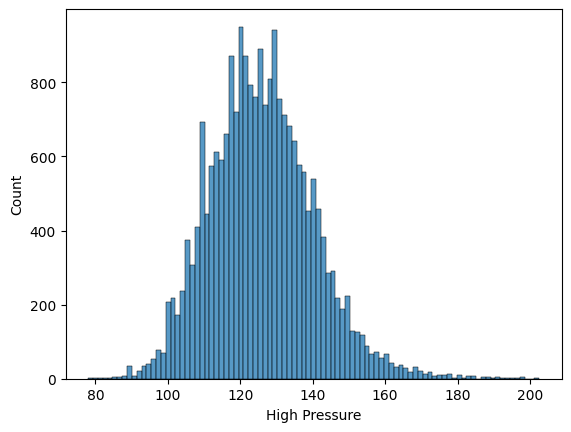

In [ ]:
sns.histplot(x=averages_bp['High Pressure'])

<Axes: xlabel='Low Pressure', ylabel='Count'>

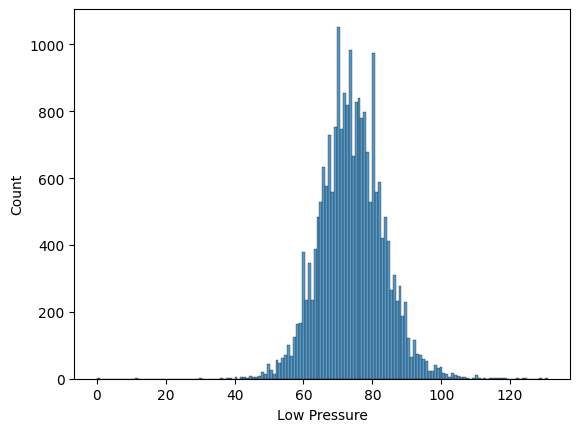

In [ ]:
sns.histplot(x=averages_bp['Low Pressure'])

In [ ]:
df_all=averages_pivot.merge(averages_bp, how='outer')
df_all

,subject_id,BMI (kg/m2),Weight (Lbs),High Pressure,Low Pressure
0,10000032,18.5375,93.104000,106.166667,64.666667
1,10000084,24.4000,170.000000,NaN,NaN
2,10000117,18.5480,111.129643,114.805556,71.847222
3,10000248,25.5000,168.000000,NaN,NaN
4,10000280,NaN,172.250000,124.500000,69.500000
...,...,...,...,...,...
25985,11648642,NaN,NaN,108.500000,65.600000
25986,11649157,NaN,NaN,110.000000,78.000000
25987,11651138,NaN,NaN,121.250000,75.250000
25988,11651486,NaN,NaN,111.000000,66.000000


In [ ]:
non_nan_bmi=df_all['BMI (kg/m2)'][df_all['BMI (kg/m2)'].isna()==False]

<Axes: xlabel='BMI (kg/m2)', ylabel='Count'>

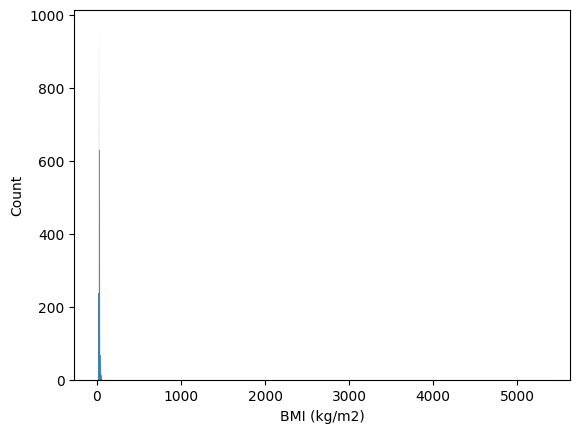

In [ ]:
sns.histplot(non_nan_bmi)

<Axes: xlabel='Weight (Lbs)', ylabel='Count'>

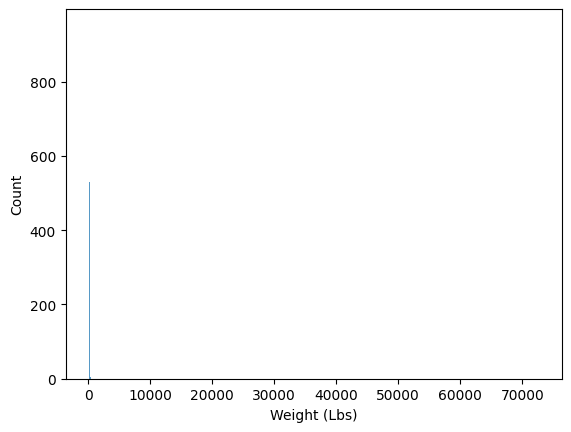

In [ ]:
non_nan_wt=df_all['Weight (Lbs)'][df_all['Weight (Lbs)'].isna()==False]
sns.histplot(non_nan_wt)

In [ ]:
df_all=df_all[(df_all['High Pressure']>=90) & (df_all['High Pressure']<=180) & (df_all['Low Pressure']>=40) & (df_all['Low Pressure']<=110)]
df_all=df_all[(df_all['BMI (kg/m2)']>=15) & (df_all['BMI (kg/m2)']<=40) & (df_all['Weight (Lbs)']>=75) & (df_all['Weight (Lbs)']<=300)]
df_all

,subject_id,BMI (kg/m2),Weight (Lbs),High Pressure,Low Pressure
0,10000032,18.537500,93.104000,106.166667,64.666667
2,10000117,18.548000,111.129643,114.805556,71.847222
6,10000635,33.985714,215.871429,142.833333,75.166667
7,10000719,37.000000,236.000000,144.000000,88.000000
9,10000826,20.900000,133.092857,99.375000,63.375000
...,...,...,...,...,...
24610,11654069,39.159375,221.152941,130.158730,62.761905
24613,11654285,36.989362,243.544043,139.611111,81.296296
24614,11654293,28.333333,150.000000,131.600000,82.800000
24617,11654368,20.800000,115.400000,107.000000,73.000000


In [ ]:
df_all.isna().sum()

subject_id       0
BMI (kg/m2)      0
Weight (Lbs)     0
High Pressure    0
Low Pressure     0
dtype: int64

<Axes: xlabel='High Pressure', ylabel='Count'>

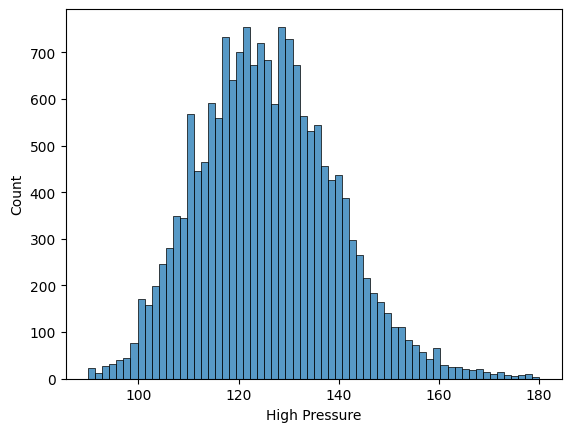

In [ ]:
sns.histplot(x=df_all['High Pressure'])

<Axes: xlabel='Low Pressure', ylabel='Count'>

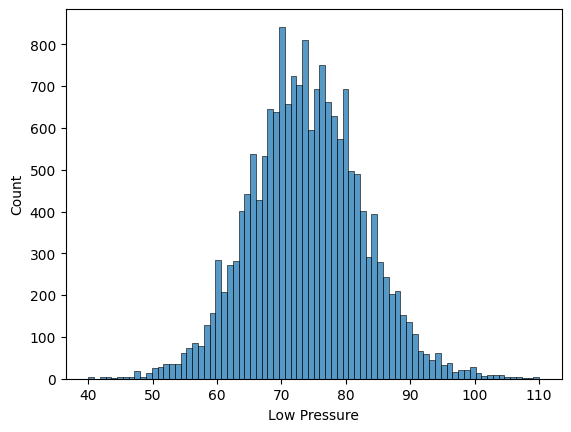

In [ ]:
sns.histplot(x=df_all['Low Pressure'])

<Axes: xlabel='BMI (kg/m2)', ylabel='Count'>

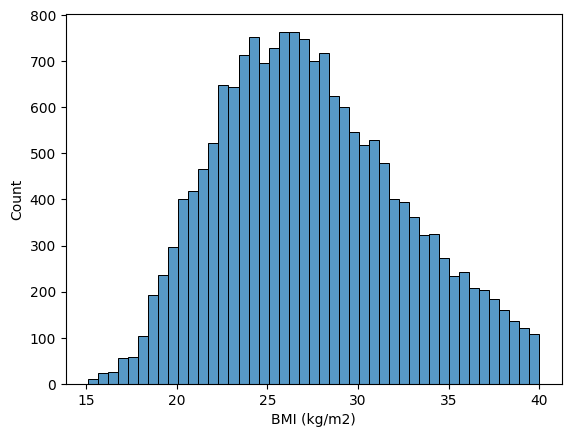

In [ ]:
sns.histplot(x=df_all['BMI (kg/m2)'])

merge all the csv files in df_merge5

In [ ]:
df_merge5=df_merge4.merge(df_all, how='outer')
df_merge5

,los,admit_hour,admit_year,admit_month,quarter,admit_time,subject_id,hadm_id,admittime,dischtime,...,race,curr_service,gender,anchor_age,anchor_year_group,drg_code,BMI (kg/m2),Weight (Lbs),High Pressure,Low Pressure
0,1.446528,8.0,2110.0,1.0,1.0,2110-01-11 08:02:00,15350437,20383396.0,2110-01-11 08:02:00,2110-01-12 18:45:00,...,WHITE,NMED,M,34,2017 - 2019,NaN,NaN,NaN,NaN,NaN
1,4.303472,10.0,2110.0,1.0,1.0,2110-01-11 10:14:00,18106347,24305596.0,2110-01-11 10:14:00,2110-01-15 17:31:00,...,WHITE,CSURG,F,48,2014 - 2016,163.0,NaN,NaN,NaN,NaN
2,4.303472,10.0,2110.0,1.0,1.0,2110-01-11 10:14:00,18106347,24305596.0,2110-01-11 10:14:00,2110-01-15 17:31:00,...,WHITE,CSURG,F,48,2014 - 2016,219.0,NaN,NaN,NaN,NaN
3,5.834722,19.0,2110.0,1.0,1.0,2110-01-11 19:58:00,16284044,23864737.0,2110-01-11 19:58:00,2110-01-17 16:00:00,...,WHITE,CSURG,F,61,2014 - 2016,166.0,NaN,NaN,NaN,NaN
4,5.834722,19.0,2110.0,1.0,1.0,2110-01-11 19:58:00,16284044,23864737.0,2110-01-11 19:58:00,2110-01-17 16:00:00,...,WHITE,CSURG,F,61,2014 - 2016,236.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
911462,NaN,NaN,NaN,NaN,NaN,NaT,19999659,NaN,NaN,NaN,...,NaN,NaN,F,58,2011 - 2013,NaN,NaN,NaN,NaN,NaN
911463,NaN,NaN,NaN,NaN,NaN,NaT,19999750,NaN,NaN,NaN,...,NaN,NaN,M,45,2017 - 2019,NaN,NaN,NaN,NaN,NaN
911464,NaN,NaN,NaN,NaN,NaN,NaT,19999782,NaN,NaN,NaN,...,NaN,NaN,F,22,2008 - 2010,NaN,NaN,NaN,NaN,NaN
911465,NaN,NaN,NaN,NaN,NaN,NaT,19999829,NaN,NaN,NaN,...,NaN,NaN,F,28,2008 - 2010,NaN,NaN,NaN,NaN,NaN


removing samples with NA entries

In [ ]:
df_merged_final=df_merge5.dropna(subset=['hadm_id', 'Weight (Lbs)', 'admit_hour', 'High Pressure', 'BMI (kg/m2)', 'drg_code'])
df_merged_final

,los,admit_hour,admit_year,admit_month,quarter,admit_time,subject_id,hadm_id,admittime,dischtime,...,race,curr_service,gender,anchor_age,anchor_year_group,drg_code,BMI (kg/m2),Weight (Lbs),High Pressure,Low Pressure
46,2.831250,16.0,2110.0,1.0,1.0,2110-01-14 16:43:00,10891365,23150870.0,2110-01-14 16:43:00,2110-01-17 12:40:00,...,WHITE,ORTHO,M,28,2011 - 2013,121.0,26.900000,148.625000,124.333333,75.666667
47,2.831250,16.0,2110.0,1.0,1.0,2110-01-14 16:43:00,10891365,23150870.0,2110-01-14 16:43:00,2110-01-17 12:40:00,...,WHITE,ORTHO,M,28,2011 - 2013,168.0,26.900000,148.625000,124.333333,75.666667
63,3.992361,19.0,2110.0,1.0,1.0,2110-01-16 19:05:00,10540472,29343161.0,2110-01-16 19:05:00,2110-01-20 18:54:00,...,WHITE,MED,F,59,2017 - 2019,683.0,23.000000,138.450000,120.000000,80.000000
78,4.539583,0.0,2110.0,1.0,1.0,2110-01-23 00:00:00,10101340,27612209.0,2110-01-23 00:00:00,2110-01-27 12:57:00,...,WHITE,ORTHO,M,60,2017 - 2019,315.0,37.243243,255.198378,143.142857,88.114286
79,4.539583,0.0,2110.0,1.0,1.0,2110-01-23 00:00:00,10101340,27612209.0,2110-01-23 00:00:00,2110-01-27 12:57:00,...,WHITE,ORTHO,M,60,2017 - 2019,483.0,37.243243,255.198378,143.142857,88.114286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
792430,3.911111,17.0,2208.0,3.0,1.0,2208-03-10 17:38:00,10721506,29960556.0,2208-03-10 17:38:00,2208-03-14 15:30:00,...,BLACK/AFRICAN AMERICAN,MED,F,46,2014 - 2016,443.0,31.260000,153.197500,140.178571,82.035714
792464,3.218750,9.0,2208.0,9.0,3.0,2208-09-20 09:15:00,10113000,29480235.0,2208-09-20 09:15:00,2208-09-23 14:30:00,...,WHITE - OTHER EUROPEAN,NSURG,M,63,2014 - 2016,320.0,31.288889,225.766667,131.500000,77.555556
792465,3.218750,9.0,2208.0,9.0,3.0,2208-09-20 09:15:00,10113000,29480235.0,2208-09-20 09:15:00,2208-09-23 14:30:00,...,WHITE - OTHER EUROPEAN,NSURG,M,63,2014 - 2016,517.0,31.288889,225.766667,131.500000,77.555556
792472,3.848611,20.0,2209.0,2.0,1.0,2209-02-24 20:38:00,11066364,28462366.0,2209-02-24 20:38:00,2209-02-28 17:00:00,...,BLACK/AFRICAN AMERICAN,SURG,M,48,2014 - 2016,244.0,34.310000,244.645000,135.848485,92.060606


In [ ]:
df_merged_final=df_merged_final[df_merged_final['deathtime'].isna()]
df_merged_final=df_merged_final.drop(columns=['deathtime', 'admittime', 'dischtime'])
df_merged_final = df_merged_final.sort_values(by='admit_time', ascending=True)

In [ ]:
df_merged_final

,los,admit_hour,admit_year,admit_month,quarter,admit_time,subject_id,hadm_id,admission_type,admission_location,...,race,curr_service,gender,anchor_age,anchor_year_group,drg_code,BMI (kg/m2),Weight (Lbs),High Pressure,Low Pressure
46,2.831250,16.0,2110.0,1.0,1.0,2110-01-14 16:43:00,10891365,23150870.0,EW EMER.,EMERGENCY ROOM,...,WHITE,ORTHO,M,28,2011 - 2013,121.0,26.900000,148.625000,124.333333,75.666667
47,2.831250,16.0,2110.0,1.0,1.0,2110-01-14 16:43:00,10891365,23150870.0,EW EMER.,EMERGENCY ROOM,...,WHITE,ORTHO,M,28,2011 - 2013,168.0,26.900000,148.625000,124.333333,75.666667
63,3.992361,19.0,2110.0,1.0,1.0,2110-01-16 19:05:00,10540472,29343161.0,OBSERVATION ADMIT,PHYSICIAN REFERRAL,...,WHITE,MED,F,59,2017 - 2019,683.0,23.000000,138.450000,120.000000,80.000000
130,6.997917,14.0,2110.0,1.0,1.0,2110-01-21 14:18:00,10872930,27206460.0,EW EMER.,EMERGENCY ROOM,...,WHITE,MED,F,79,2008 - 2010,391.0,25.325000,131.731707,123.300000,57.400000
129,6.997917,14.0,2110.0,1.0,1.0,2110-01-21 14:18:00,10872930,27206460.0,EW EMER.,EMERGENCY ROOM,...,WHITE,MED,F,79,2008 - 2010,254.0,25.325000,131.731707,123.300000,57.400000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
787692,1.568750,2.0,2210.0,12.0,4.0,2210-12-10 02:58:00,10252385,26731788.0,OBSERVATION ADMIT,WALK-IN/SELF REFERRAL,...,BLACK/AFRICAN AMERICAN,CMED,F,32,2008 - 2010,198.0,34.053247,213.803506,127.339130,76.069565
787695,2.667361,0.0,2210.0,12.0,4.0,2210-12-24 00:02:00,10252385,25798254.0,OBSERVATION ADMIT,WALK-IN/SELF REFERRAL,...,BLACK/AFRICAN AMERICAN,MED,F,32,2008 - 2010,103.0,34.053247,213.803506,127.339130,76.069565
787694,2.667361,0.0,2210.0,12.0,4.0,2210-12-24 00:02:00,10252385,25798254.0,OBSERVATION ADMIT,WALK-IN/SELF REFERRAL,...,BLACK/AFRICAN AMERICAN,MED,F,32,2008 - 2010,54.0,34.053247,213.803506,127.339130,76.069565
788285,2.821528,18.0,2211.0,4.0,2.0,2211-04-07 18:00:00,10578807,26264376.0,OBSERVATION ADMIT,WALK-IN/SELF REFERRAL,...,ASIAN - CHINESE,MED,F,58,2008 - 2010,246.0,24.640000,126.404000,118.312500,72.656250


In [ ]:
df_merged_final=df_merged_final.drop(columns=['admit_time', 'subject_id', 'hadm_id', 'language'], axis=1)

perform label encoding on catagorical features

In [ ]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
df_merged_final['admission_type'] = labelencoder.fit_transform(df_merged_final['admission_type'])
df_merged_final['admission_location'] = labelencoder.fit_transform(df_merged_final['admission_location'])
df_merged_final['discharge_location'] = labelencoder.fit_transform(df_merged_final['discharge_location'])
df_merged_final['insurance'] = labelencoder.fit_transform(df_merged_final['insurance'])
df_merged_final['marital_status'] = labelencoder.fit_transform(df_merged_final['marital_status'])
df_merged_final['race'] = labelencoder.fit_transform(df_merged_final['race'])
df_merged_final['curr_service'] = labelencoder.fit_transform(df_merged_final['curr_service'])
df_merged_final['gender'] = labelencoder.fit_transform(df_merged_final['gender'])
df_merged_final['anchor_year_group'] = labelencoder.fit_transform(df_merged_final['anchor_year_group'])
df_merged_final

,los,admit_hour,admit_year,admit_month,quarter,admission_type,admission_location,discharge_location,insurance,marital_status,race,curr_service,gender,anchor_age,anchor_year_group,drg_code,BMI (kg/m2),Weight (Lbs),High Pressure,Low Pressure
46,2.831250,16.0,2110.0,1.0,1.0,5,2,6,2,2,28,11,1,28,1,121.0,26.900000,148.625000,124.333333,75.666667
47,2.831250,16.0,2110.0,1.0,1.0,5,2,6,2,2,28,11,1,28,1,168.0,26.900000,148.625000,124.333333,75.666667
63,3.992361,19.0,2110.0,1.0,1.0,6,6,6,2,2,28,6,0,59,3,683.0,23.000000,138.450000,120.000000,80.000000
130,6.997917,14.0,2110.0,1.0,1.0,5,2,12,2,1,28,6,0,79,0,391.0,25.325000,131.731707,123.300000,57.400000
129,6.997917,14.0,2110.0,1.0,1.0,5,2,12,2,1,28,6,0,79,0,254.0,25.325000,131.731707,123.300000,57.400000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
787692,1.568750,2.0,2210.0,12.0,4.0,6,10,6,1,2,7,0,0,32,0,198.0,34.053247,213.803506,127.339130,76.069565
787695,2.667361,0.0,2210.0,12.0,4.0,6,10,6,1,2,7,6,0,32,0,103.0,34.053247,213.803506,127.339130,76.069565
787694,2.667361,0.0,2210.0,12.0,4.0,6,10,6,1,2,7,6,0,32,0,54.0,34.053247,213.803506,127.339130,76.069565
788285,2.821528,18.0,2211.0,4.0,2.0,6,10,6,1,2,3,6,0,58,0,246.0,24.640000,126.404000,118.312500,72.656250


In [ ]:
na_df=df_merged_final.isna().sum()
na_df

los                   0
admit_hour            0
admit_year            0
admit_month           0
quarter               0
admission_type        0
admission_location    0
discharge_location    0
insurance             0
marital_status        0
race                  0
curr_service          0
gender                0
anchor_age            0
anchor_year_group     0
drg_code              0
BMI (kg/m2)           0
Weight (Lbs)          0
High Pressure         0
Low Pressure          0
dtype: int64

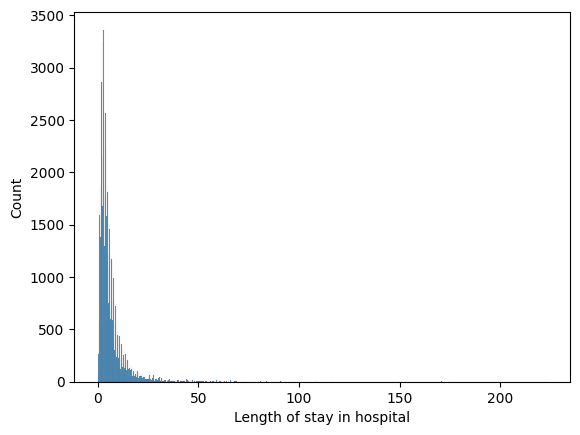

In [ ]:
fig, ax = plt.subplots()
sns.histplot(df_merged_final.los, cbar_ax=ax)
#ax.set_xlim(1, 200)
plt.xlabel("Length of stay in hospital")
plt.show()

In [ ]:
df_merged_final.los.mean()
df_merged_final.los.median()
percentile_80 = np.percentile(df_merged_final.los, 80)

print("80th percentile:", percentile_80)

80th percentile: 8.141805555555564


taking 80th percentile as a cut off point for LOS

In [ ]:
df_merged_final=df_merged_final[df_merged_final['los']<8]
df_merged_final

,los,admit_hour,admit_year,admit_month,quarter,admission_type,admission_location,discharge_location,insurance,marital_status,race,curr_service,gender,anchor_age,anchor_year_group,drg_code,BMI (kg/m2),Weight (Lbs),High Pressure,Low Pressure
46,2.831250,16.0,2110.0,1.0,1.0,5,2,6,2,2,28,11,1,28,1,121.0,26.900000,148.625000,124.333333,75.666667
47,2.831250,16.0,2110.0,1.0,1.0,5,2,6,2,2,28,11,1,28,1,168.0,26.900000,148.625000,124.333333,75.666667
63,3.992361,19.0,2110.0,1.0,1.0,6,6,6,2,2,28,6,0,59,3,683.0,23.000000,138.450000,120.000000,80.000000
130,6.997917,14.0,2110.0,1.0,1.0,5,2,12,2,1,28,6,0,79,0,391.0,25.325000,131.731707,123.300000,57.400000
129,6.997917,14.0,2110.0,1.0,1.0,5,2,12,2,1,28,6,0,79,0,254.0,25.325000,131.731707,123.300000,57.400000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
787692,1.568750,2.0,2210.0,12.0,4.0,6,10,6,1,2,7,0,0,32,0,198.0,34.053247,213.803506,127.339130,76.069565
787695,2.667361,0.0,2210.0,12.0,4.0,6,10,6,1,2,7,6,0,32,0,103.0,34.053247,213.803506,127.339130,76.069565
787694,2.667361,0.0,2210.0,12.0,4.0,6,10,6,1,2,7,6,0,32,0,54.0,34.053247,213.803506,127.339130,76.069565
788285,2.821528,18.0,2211.0,4.0,2.0,6,10,6,1,2,3,6,0,58,0,246.0,24.640000,126.404000,118.312500,72.656250


<Axes: >

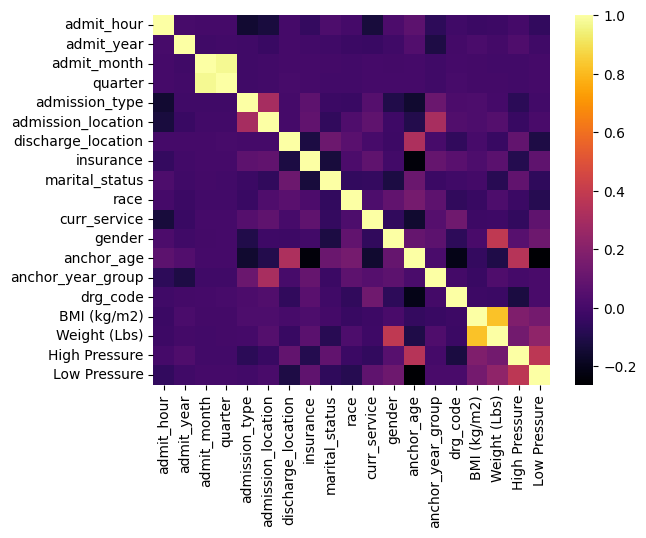

In [ ]:
sns.heatmap(df_merged_final.drop(columns='los').corr(), cmap='inferno')

<Axes: xlabel='Weight (Lbs)', ylabel='BMI (kg/m2)'>

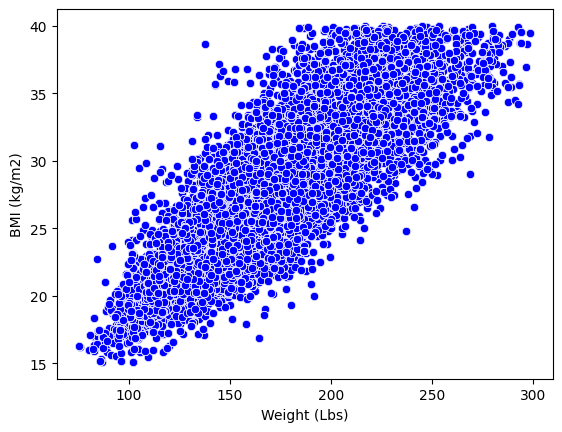

In [ ]:
sns.scatterplot(data=df_merged_final, x='Weight (Lbs)', y='BMI (kg/m2)', color='blue')

<Axes: xlabel='admit_month', ylabel='quarter'>

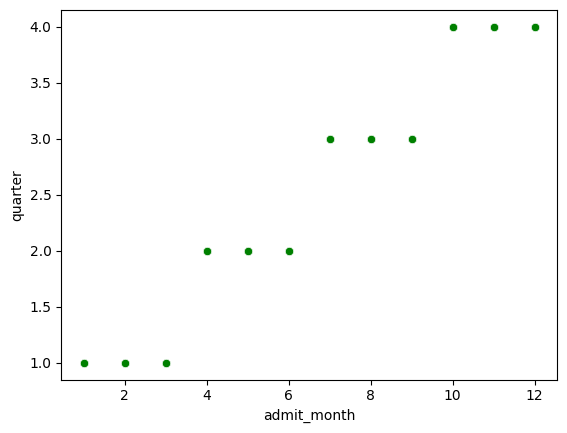

In [ ]:
sns.scatterplot(data=df_merged_final, x='admit_month', y='quarter', color='green')

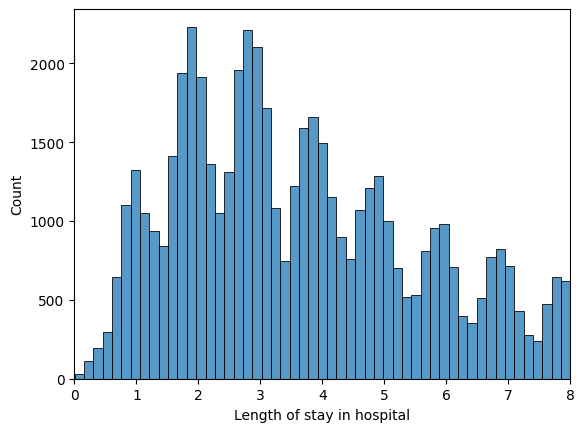

In [ ]:
fig, ax = plt.subplots()
sns.histplot(df_merged_final.los, cbar_ax=ax)
ax.set_xlim(0, 8)
plt.xlabel("Length of stay in hospital")
plt.show()

In [ ]:
df_merged_final=df_merged_final.drop(columns=['Weight (Lbs)','quarter'])

<Axes: >

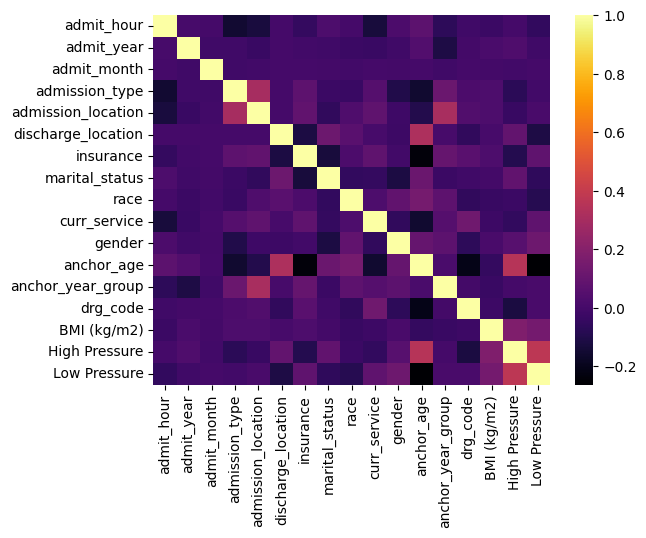

In [ ]:
sns.heatmap(df_merged_final.drop(columns='los').corr(), cmap='inferno')

In [ ]:
df_merged_final['BMI (kg/m2)']=df_merged_final['BMI (kg/m2)'].astype(float)
df_merged_final['High Pressure']=df_merged_final['High Pressure'].astype(int)
df_merged_final['Low Pressure']=df_merged_final['Low Pressure'].astype(int)
df_merged_final['drg_code']=df_merged_final['drg_code'].astype(int)
df_merged_final.iloc[:, 1:-3]=df_merged_final.iloc[:, 1:-3].astype(int)

<ipython-input-44-ce2f82d80714>:5: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_merged_final.iloc[:, 1:-3]=df_merged_final.iloc[:, 1:-3].astype(int)


spliting df_merged_final in training and testing data

In [ ]:
X=df_merged_final.iloc[:, 1:]
y=df_merged_final['los']

from sklearn.model_selection import train_test_split

# Set the ratio for splitting (e.g., 80% training and 20% testing)
ratio = 0.8

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1-ratio, shuffle=False)

perform XGBoost on the training and testing data

In [ ]:
reg = xgb.XGBRegressor(base_score=3.5, booster='gbtree',
                       n_estimators=2000,
                       early_stopping_rounds=40,
                       objective='reg:squarederror',
                       subsample=0.6,
                       colsample_bytree=0.6,
                       max_depth=4,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:1.90779	validation_1-rmse:1.87599
[100]	validation_0-rmse:1.79490	validation_1-rmse:1.77274
[200]	validation_0-rmse:1.74168	validation_1-rmse:1.72617
[300]	validation_0-rmse:1.71697	validation_1-rmse:1.70695
[400]	validation_0-rmse:1.70077	validation_1-rmse:1.69699
[500]	validation_0-rmse:1.68780	validation_1-rmse:1.69045
[600]	validation_0-rmse:1.67651	validation_1-rmse:1.68532
[700]	validation_0-rmse:1.66646	validation_1-rmse:1.68098
[800]	validation_0-rmse:1.65713	validation_1-rmse:1.67743
[900]	validation_0-rmse:1.64902	validation_1-rmse:1.67503
[1000]	validation_0-rmse:1.64085	validation_1-rmse:1.67244
[1100]	validation_0-rmse:1.63321	validation_1-rmse:1.66993
[1200]	validation_0-rmse:1.62583	validation_1-rmse:1.66757
[1300]	validation_0-rmse:1.61895	validation_1-rmse:1.66570
[1400]	validation_0-rmse:1.61276	validation_1-rmse:1.66453
[1500]	validation_0-rmse:1.60651	validation_1-rmse:1.66312
[1600]	validation_0-rmse:1.59999	validation_1-rmse:1.66147
[1700]	va

XGBRegressor(base_score=3.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6, early_stopping_rounds=40,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=2000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [ ]:
prediction=reg.predict(X_test)

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score

In [ ]:
xgb_score_MAE = mean_absolute_error(y_test, prediction)
xgb_score_RMSE = np.sqrt(mean_squared_error(y_test, prediction))
xgb_score_MAPE = mean_absolute_percentage_error(y_test, prediction)
print(f'MAE Score on Test set: {xgb_score_MAE:0.2f}')
print(f'RMSE Score on Test set: {xgb_score_RMSE:0.2f}')
print(f'MAPE Score on Test set: {xgb_score_MAPE:0.2f}')

MAE Score on Test set: 1.35
RMSE Score on Test set: 1.66
MAPE Score on Test set: 0.59


Visualize XGBoost prediction vs actual values

In [ ]:
mean_actual = np.mean(y_test)
mean_actual

3.590574999204759

In [ ]:
mean_pred = np.mean(prediction)
mean_pred

3.5281944

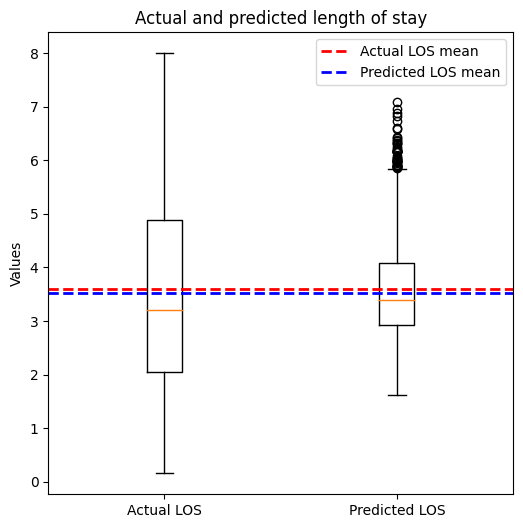

In [ ]:
# Combine the data into a list for plotting
data_to_plot = [y_test, prediction]
plt.figure(figsize=(6,6))

# Create the boxplots
plt.boxplot(data_to_plot)

# Add horizontal lines representing the mean values for each boxplot
plt.axhline(mean_actual, color='red', linestyle='dashed', linewidth=2, label='Actual LOS mean')
plt.axhline(mean_pred, color='blue', linestyle='dashed', linewidth=2, label='Predicted LOS mean')

# Set labels for the boxplots
plt.xticks([1, 2], ['Actual LOS', 'Predicted LOS'])

# Add labels and title
plt.ylabel('Values')
plt.title('Actual and predicted length of stay')
plt.legend()

# Display the plot
plt.show()

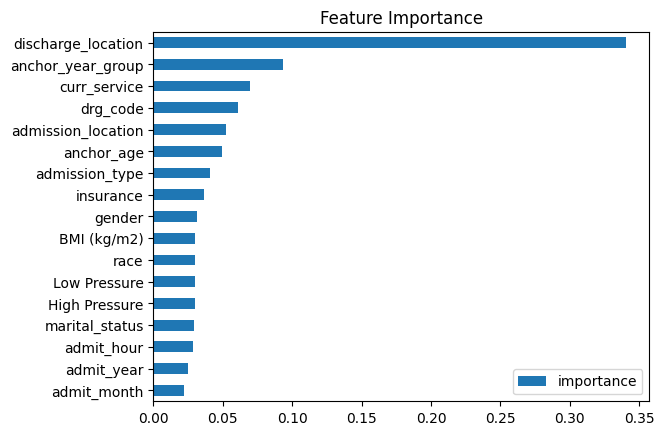

In [ ]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

Compare other relevant methods with XGBoost

In [ ]:
from sklearn.ensemble import RandomForestRegressor
# Create a Random Forest Regressor instance
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model on the training data
rf_regressor.fit(X_train, y_train)

# Make predictions on the test data
y_pred = rf_regressor.predict(X_test)

rf_score_MAE = mean_absolute_error(y_test, y_pred)
rf_score_RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
rf_score_MAPE = mean_absolute_percentage_error(y_test, y_pred)
print(f'MAE Score on Test set: {rf_score_MAE:0.2f}')
print(f'RMSE Score on Test set: {rf_score_RMSE:0.2f}')
print(f'MAPE Score on Test set: {rf_score_MAPE:0.2f}')

MAE Score on Test set: 1.40
RMSE Score on Test set: 1.71
MAPE Score on Test set: 0.64


In [ ]:
from sklearn.linear_model import LinearRegression

linear_regressor = LinearRegression()

# Train the model on the training data
linear_regressor.fit(X_train, y_train)

# Make predictions on the test data
y_pred = linear_regressor.predict(X_test)

lr_score_MAE = mean_absolute_error(y_test, y_pred)
lr_score_RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
lr_score_MAPE = mean_absolute_percentage_error(y_test, y_pred)
print(f'MAE Score on Test set: {lr_score_MAE:0.2f}')
print(f'RMSE Score on Test set: {lr_score_RMSE:0.2f}')
print(f'MAPE Score on Test set: {lr_score_MAPE:0.2f}')

MAE Score on Test set: 1.47
RMSE Score on Test set: 1.78
MAPE Score on Test set: 0.66


In [ ]:
model = keras.Sequential([
    layers.Dense(1, activation='relu', input_shape=(17,)),
    layers.Dense(5, activation='relu'),
    layers.Dense(1)  # Output layer with one neuron for regression
])

# Compile the model
learning_rate = 0.01
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics='mae')

# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=100)

y_pred = model.predict(X_test)
nn_score_MAE = mean_absolute_error(y_test, y_pred)
nn_score_RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
nn_score_MAPE = mean_absolute_percentage_error(y_test, y_pred)
print(f'MAE Score on Test set: {nn_score_MAE:0.2f}')
print(f'RMSE Score on Test set: {nn_score_RMSE:0.2f}')
print(f'MAPE Score on Test set: {nn_score_MAPE:0.2f}')

Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
328/328 [==============================] - 1s 2ms/step
MAE Score on Test set: 1.56
RMSE Score on Test set: 1.88
MAPE Score on Test set: 0.73


XGBoost has the best performance in regards of MAE (1.35), RMSE (1.66) and MAPE (0.59)



Interpret the results with SHAP

In [ ]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 5.5 MB/s eta 0:00:00


In [ ]:
#Prepare SHAP
import shap
explainer = shap.TreeExplainer(reg)
shap_values = explainer.shap_values(X_test)

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [ ]:
X_test

,admit_hour,admit_year,admit_month,admission_type,admission_location,discharge_location,insurance,marital_status,race,curr_service,gender,anchor_age,anchor_year_group,drg_code,BMI (kg/m2),High Pressure,Low Pressure
640931,20,2180,12,5,2,6,2,1,28,6,0,58,0,314,24.032051,131,72
640930,20,2180,12,5,2,6,2,1,28,14,0,58,0,628,24.032051,131,72
640932,20,2180,12,5,2,6,2,1,28,6,0,58,0,628,24.032051,131,72
640929,20,2180,12,5,2,6,2,1,28,14,0,58,0,314,24.032051,131,72
667077,0,2180,12,6,6,12,1,1,28,6,1,91,3,698,19.871429,147,63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
787692,2,2210,12,6,10,6,1,2,7,0,0,32,0,198,34.053247,127,76
787695,0,2210,12,6,10,6,1,2,7,6,0,32,0,103,34.053247,127,76
787694,0,2210,12,6,10,6,1,2,7,6,0,32,0,54,34.053247,127,76
788285,18,2211,4,6,10,6,1,2,3,6,0,58,0,246,24.640000,118,72


In [ ]:
#local interpretability
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.loc[640931])

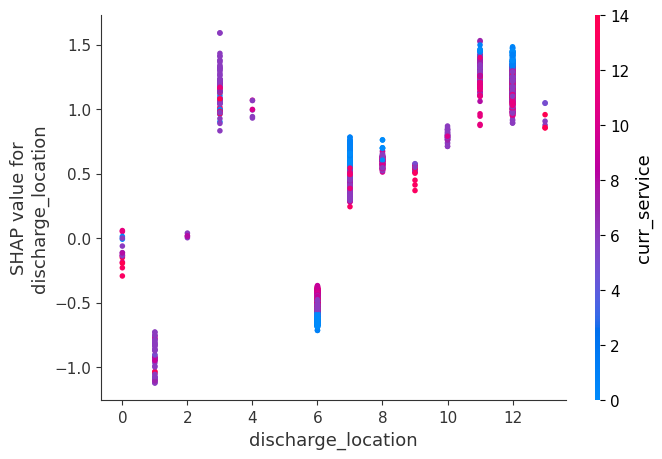

In [ ]:
#Dependence plots
shap.dependence_plot("discharge_location", shap_values, X_test)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


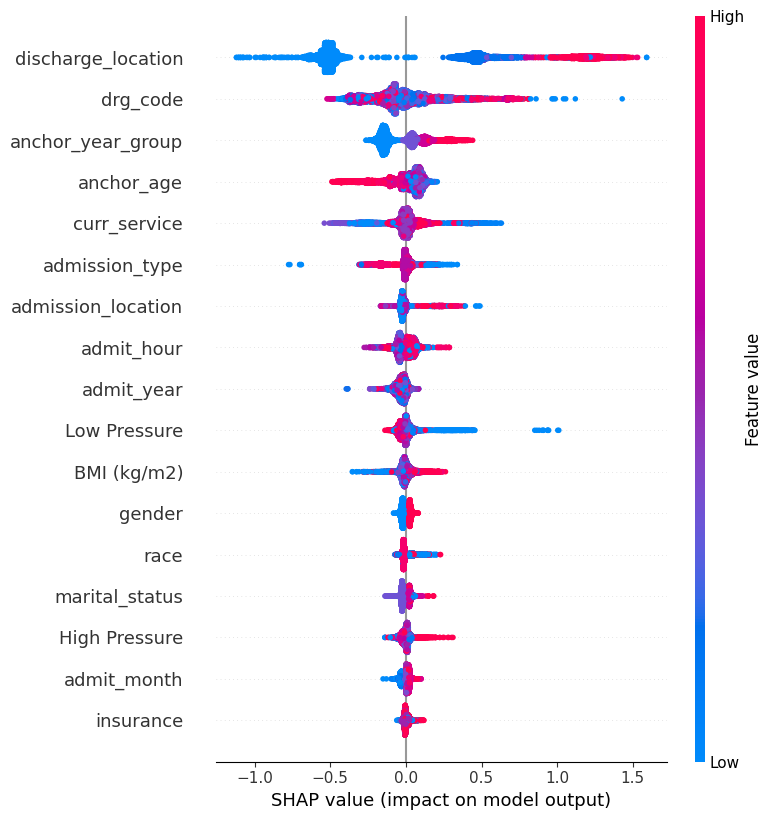

In [ ]:
#Global Interpretability
shap.summary_plot(shap_values, X_test)